In [7]:
import pandas as pd

# Load only a portion (e.g., first 10,000 rows)
df = pd.read_csv("Tweets.csv", nrows=5000)
df.head()
#df['airline'].unique()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
df = df[['airline_sentiment', 'text']].dropna()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [11]:
#Clean the text
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)          # remove URLs
    text = re.sub(r'@\w+', '', text)             # remove mentions
    text = re.sub(r'#\w+', '', text)             # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)      # remove punctuation and numbers
    text = text.lower()                          # lowercase all text
    text = re.sub(r'\s+', ' ', text).strip()     # remove extra spaces
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()

,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it


In [12]:
#Converting the words into numericals so that our ML model can understand.
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
vectorizer = TfidfVectorizer(max_features=3000)  # You can adjust this number for speed/performance

# Fit and transform the cleaned text
X = vectorizer.fit_transform(df['clean_text'])

# Optional: View shape of feature matrix
print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (5000, 3000)


In [13]:
#Encoding airline_sentiment to numericals
from sklearn.preprocessing import LabelEncoder

# Initialize and apply label encoder
le = LabelEncoder()
y = le.fit_transform(df['airline_sentiment'])

# Optional: Check what each class maps to
print(le.classes_)       # ['negative' 'neutral' 'positive']
print(set(y))            # Should show {0, 1, 2}


['negative' 'neutral' 'positive']
{np.int64(0), np.int64(1), np.int64(2)}


In [14]:
#Splitting the dataset
from sklearn.model_selection import train_test_split

# 80% training, 20% testing — stratify keeps sentiment classes balanced
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Train set size: 4000
Test set size: 1000


In [15]:
#Fitting the model
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
model = LogisticRegression(max_iter=1000)  # Increase max_iter to ensure convergence
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [17]:
#Make Predictions 
y_pred = model.predict(X_test)
#print(y_pred)

In [18]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.745

Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.96      0.84       626
     neutral       0.66      0.36      0.47       211
    positive       0.80      0.43      0.56       163

    accuracy                           0.74      1000
   macro avg       0.74      0.58      0.62      1000
weighted avg       0.74      0.74      0.72      1000



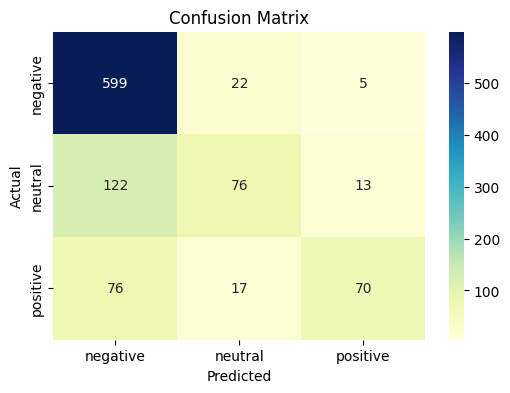

In [19]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
